In [13]:
pip install --upgrade --pre "tiled[all]" "databroker[all]"

Note: you may need to restart the kernel to use updated packages.


In [14]:
import tiled, databroker,PyHyperScattering
PyHyperScattering.__version__,tiled.__version__, databroker.__version__

('0.1.0a103', '2.0.0b26')

In [46]:
from tiled.server.app import build_app
from tiled.catalog import from_uri
from tiled.client import Context, from_context, from_profile
import xarray as xr
import tiled, databroker,PyHyperScattering
c = from_context(Context.from_app(build_app(from_uri("sqlite+aiosqlite:///./catalog.db", writable_storage="./data", init_if_not_exists=True))))
from tiled.client.xarray import write_xarray_dataset

import PyHyperScattering
print(f'{PyHyperScattering.__version__}')


def analyze_run_NEXAFS(
    scanID: int,
    againstTime: bool = False,
    energyDim: str = 'en_monoen_readback',
    renameVars: bool = True,
    customMonitorMapping: dict = None,
) -> xr.Dataset:
    """Loads raw NEXAFS Run data from tiled into an xarray Dataset. Modeled on PyHyperScattering SST1RSoXSDB loadRun

    Parameters
    ----------
    scanID : int or databroker.client.BlueskyRun
            scan number (int) or Bluesky Document containing run information.
    againstTime : bool, optional
        whether to leave monitors with a shared time dimension or swap dims to energy, by default False
    energyDim : str, optional
        name of the monitor to use as the energy dimension, by default 'en_monoen_readback'
    renameVars : bool, optional
        Whether to try to rename variables to scientific names, by default True
        Variables will be renamed to 'energy','TEY','i0','SAXS Beamstop', 'WAXS Beamstop' or m_[original name].
        The original name of each monitor is saved as the monitorName variable in the attributes of the dataArray
        If monitor stream names aren't found, the function will throw an error reqesting a custom Monitor Mapping dict
    customMonitorMapping : dict, optional
        A dictionary that maps any or all of 'energy','TEY','i0','SAXS Beamstop', 'WAXS Beamstop' to monitor stream names. 
        This mapping supersedes the hardcoded mapping. 
        ex: {'energy':'en_monoen_en'}
    Returns
    -------
    xr.Dataset
        xarray Dataset containing monitor channels and scan metadata
    """

    # Pull bluesky run catalog entry
    if isinstance(scanID, int):
        # Create catalog
        catalog = tiled.client.from_profile("rsoxs")
        bsrun = catalog[scanID]
    elif isinstance(scanID, databroker.client.BlueskyRun):
        bsrun = scanID
    else:
        raise TypeError(
            "scanID must be an int or a databroker.client.BlueskyRun object"
        )

    # Load monitor streams with original names
    ds_monitors = None
    
    # Iterate through the list of streams held by the Bluesky document 'entry'
    for stream_name in list(bsrun.keys()):
        # Add monitor streams to the output xr.Dataset
        if "monitor" in stream_name:
            if ds_monitors is None:  # First one
                # incantation to extract the dataset from the bluesky stream
                ds_monitors = bsrun[stream_name].data.read()
            else:  # merge into the to existing output xr.Dataset
                ds_monitors = xr.merge((ds_monitors, bsrun[stream_name].data.read()))

        # At this stage monitors have dimension time and all streams as data variables
        # the time dimension inherited all time values from all streams
        # the data variables (Mesh current, sample current etc.) are all sparse, with lots of nans

    # For each nan value, replace with the closest value ahead of it in time
    # For remaining nans, replace with closest value behind it in time
    ds_monitors = ds_monitors.ffill("time").bfill("time")

    # Append metadata from the start dict
    runMD = bsrun.start
    runMD["plan_details"] = runMD["acq_history"][-1]
    ds_monitors.attrs = runMD

    # Swap dimensions to energy, if requested
    if againstTime == True:
        # do nothing
        pass
    else: # Swap dimensions to energy
        ds_monitors = ds_monitors.swap_dims({"time": energyDim})
        # drop time dimension
        del ds_monitors["time"]
        
    # Rename variables, if requested    
    if renameVars:
        # Default mapping as of 2023-2
        defaultMonitors = {
            'energy': energyDim,
            'TEY':'RSoXS Sample Current',
            'i0': 'RSoXS Au Mesh Current',
            'SAXS Beamstop':'SAXS Beamstop',
            'WAXS Beamstop':'WAXS Beamstop',
        }
        
        # Create mapping for this process from default and any overrides
        thisMap = defaultMonitors
        if customMonitorMapping is not None:
            for key in customMonitorMapping:
                thisMap[key] = customMonitorMapping[key]
        
        # Rename variables based on mapping
        for key in thisMap:
            ds_monitors = ds_monitors.rename_vars({thisMap[key]: key})
            ds_monitors[key].attrs['monitorName'] = thisMap[key]
        
        # Rename extra variables
        for da_name in ds_monitors:
            if da_name not in thisMap.keys():
                ds_monitors[da_name].attrs['monitorName'] = da_name
                ds_monitors = ds_monitors.rename_vars({da_name: "m_" + da_name})
        
    return ds_monitors


def analyze_run_rsoxs(run):
    '''
    live-analysis function for RSoXS scans
    
    Parameters:
        run (int): the local scan id from DataBroker or uid
    '''
    c = from_profile('rsoxs')
    rsoxsload = PyHyperScattering.load.SST1RSoXSDB(corr_mode='none', catalog=c)
    
    itp = rsoxsload.loadRun(c[run],dims=['energy'])

    maskpath = None
    maskpoints = None
    maskshape = None
    
    try:
        if itp.rsoxs_config == 'waxs':
            maskmethod = 'polygon'
            maskpoints = [itp.start['WAXS_Mask']]
            maskshape = (1024,1026)
        elif itp.rsoxs_config == 'saxs':
            maskmethod = 'polygon'
            maskpoints = [itp.start['SAXS_Mask']]
            maskshape = (1024,1026)
        else:
            maskmethod = 'none'
            warnings.warn(f'Bad rsoxs_config, expected saxs or waxs but found {itp.rsoxs_config}.  This will disable masking and certainly cause issues later.',stacklevel=2)
    except KeyError:
        maskmethod = 'none'
        warnings.warn(f'KeyError while attempting to load mask from metadata',stacklevel=2)

    integ = PyHyperScattering.integrate.PFEnergySeriesIntegrator(maskmethod=maskmethod,maskpath=maskpath,maskpoints = maskpoints, maskshape=maskshape,geomethod='template_xr',template_xr=itp,integration_method='csr_ocl')

    integratedimages = integ.integrateImageStack(itp)
    
    return integratedimages

def analyze_and_upload(run):
    try:
        analyzed_data = analyze_run(run).unstack('system')
        analyzed_dataset = xr.Dataset({'x':analyzed_data})
    except Exception:
        try:
            analyzed_dataset = analyze_run_NEXAFS(run)
        # not RSoXS - so try NEXAFS
        except Exception:
            analyzed_dataset = xr.Dataset()
    uploaded_dataset = write_xarray_dataset(c, analyzed_dataset)
    return uploaded_dataset

OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_065_958 bytes (15% of total physical RAM)


0.2.1


In [43]:
test2 = analyze_and_upload(67621)

OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_065_958 bytes (15% of total physical RAM)


In [47]:
test2 = analyze_run_NEXAFS(67621)

OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_065_958 bytes (15% of total physical RAM)


In [53]:
c

<Container {'25790553-1ded-4e9a-bb24-70870c00ebe2', ...} ~12 entries>

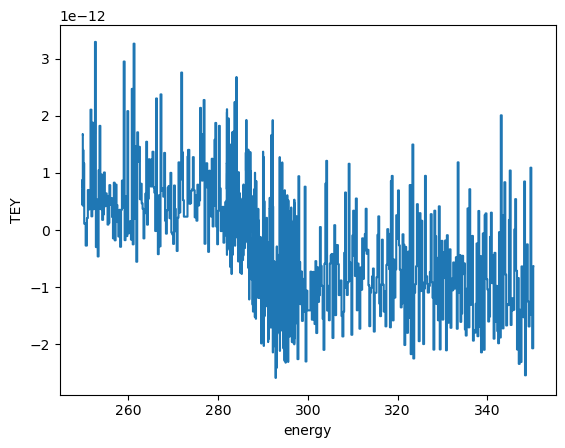

In [52]:
test2.TEY.plot(x='energy')

In [16]:
ds

<xarray.Dataset>
Dimensions:  (energy: 114, chi: 360, q: 500)
Coordinates:
  * energy   (energy) float64 250.0 255.0 260.0 265.0 ... 340.0 345.0 350.0
  * chi      (chi) float64 -179.1 -178.1 -177.1 -176.1 ... 177.1 178.1 179.1
  * q        (q) float64 0.0002413 0.0004951 0.000749 ... 0.1264 0.1267 0.1269
Data variables:
    x        (chi, q, energy) float64 nan nan nan nan nan ... nan nan nan nan

In [17]:
test.dims

('chi', 'q', 'energy')

In [18]:
ds['x']['energy']

<xarray.DataArray 'energy' (energy: 114)>
array([250. , 255. , 260. , 265. , 270. , 271. , 272. , 273. , 274. , 275. ,
       276. , 277. , 278. , 279. , 280. , 281. , 282. , 282.1, 282.2, 282.3,
       282.4, 282.5, 282.6, 282.7, 282.8, 282.9, 283. , 283.1, 283.2, 283.3,
       283.4, 283.5, 283.6, 283.7, 283.8, 283.9, 284. , 284.1, 284.2, 284.3,
       284.4, 284.5, 284.6, 284.7, 284.8, 284.9, 285. , 285.1, 285.2, 285.3,
       285.4, 285.5, 285.6, 285.7, 285.8, 285.9, 286. , 286.1, 286.2, 286.3,
       286.4, 286.5, 286.6, 286.7, 286.8, 286.9, 287. , 287.2, 287.4, 287.6,
       287.8, 288. , 288.2, 288.4, 288.6, 288.8, 289. , 289.2, 289.4, 289.6,
       289.8, 290. , 290.2, 290.4, 290.6, 290.8, 291. , 291.2, 291.4, 291.6,
       291.8, 292. , 293. , 294. , 295. , 296. , 297. , 298. , 299. , 300. ,
       301. , 302. , 303. , 304. , 305. , 310. , 315. , 320. , 325. , 330. ,
       335. , 340. , 345. , 350. ])
Coordinates:
  * energy   (energy) float64 250.0 255.0 260.0 265.0 ... 340.0 345.0 350.0

In [19]:
c

<Container {'25790553-1ded-4e9a-bb24-70870c00ebe2', ...} ~2 entries>

In [ ]:
from tiled.client import from_profile
c = from_profile('rsoxs')
run = c[61876]
run['primary']['data']['Wide Angle CCD Detector_image'][0]

In [ ]:
run['primary']['data']['Wide Angle CCD Detector_image'][0]

In [ ]:
a = {}
a['eliot'] = 'good'

In [ ]:
a.update(a)

In [ ]:
a